In [1]:
import tensorflow as tf
import tensorflow
import sklearn
import math
import keras
import numpy
import pandas
import os
import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.image as mpimg
import matplotlib.pyplot
from keras.models import Sequential,Model
from keras.losses import categorical_crossentropy
from keras.layers import Dense, Conv2D, Conv1D, Conv3D, Flatten,Activation,MaxPool1D,MaxPooling1D,Dropout,LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.layers import Lambda, Input, Dense
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard

Image dimenssions

In [2]:
img_size1 = 4
img_size2 = 1
num_channels = 1
latent_space_dim =24

In [3]:
#################################### Encoder #######################################
x = tensorflow.keras.layers.Input(shape=(img_size1, img_size2, num_channels), name="encoder_input")
encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer4)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer4)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer4)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample
encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])
encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
encoder.summary()
#########################################################################################



Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 4, 1, 1)]            0         []                            
                                                                                                  
 encoder_conv_1 (Conv2D)     (None, 4, 1, 32)             320       ['encoder_input[0][0]']       
                                                                                                  
 encoder_norm_2 (BatchNorma  (None, 4, 1, 32)             128       ['encoder_conv_1[0][0]']      
 lization)                                                                                        
                                                                                                  
 encoder_activ_layer_2 (Lea  (None, 4, 1, 32)             0         ['encoder_norm_2

In [4]:
#################################### Decoder ####################################
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=(2,1), name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=(2,1), name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()
####################################################################################

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 24)]              0         
                                                                 
 decoder_dense_1 (Dense)     (None, 64)                1600      
                                                                 
 reshape (Reshape)           (None, 1, 1, 64)          0         
                                                                 
 decoder_conv_tran_1 (Conv2  (None, 2, 1, 64)          36928     
 DTranspose)                                                     
                                                                 
 decoder_norm_1 (BatchNorma  (None, 2, 1, 64)          256       
 lization)                                                       
                                                                 
 decoder_leakyrelu_1 (Leaky  (None, 2, 1, 64)        

In [5]:
#################################### Variational AutoEncoder ######################
vae_input = tensorflow.keras.layers.Input(shape=(img_size1, img_size2, num_channels), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()
###################################################################################

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 4, 1, 1)]         0         
                                                                 
 encoder_model (Functional)  (None, 24)                96688     
                                                                 
 decoder_model (Functional)  (None, 4, 1, 1)           94849     
                                                                 
Total params: 191537 (748.19 KB)
Trainable params: 190769 (745.19 KB)
Non-trainable params: 768 (3.00 KB)
_________________________________________________________________


In [6]:
#################################### Loss fuction Claculating ######################
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance): 
        kl_loss_factor = 1
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss * kl_loss_factor

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)
        loss = reconstruction_loss + kl_loss
        return loss
    return vae_loss
vae.compile(loss=loss_func(encoder_mu, encoder_log_variance), optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001))
encoder.compile(loss=loss_func(encoder_mu, encoder_log_variance), optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001))
decoder.compile(optimizer='adam', loss='mean_squared_error')
# early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
########################################################################

In [7]:
##########################################   Image 1 preparation #######################################
datasetf2001 = pd.read_csv('D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/insitu_MH_2001.csv')
data2001=np.array(datasetf2001.iloc[:, 2:6])
datay=np.array(datasetf2001.iloc[:, 6:7])
x_train2001, x_test2001 = train_test_split(data2001, test_size = 0.3, random_state = 0)
y_train, y_test = train_test_split(datay, test_size = 0.3, random_state = 0)
x_train2001 = numpy.reshape(x_train2001, newshape=(x_train2001.shape[0], x_train2001.shape[1],1,1))
x_test2001 = numpy.reshape(x_test2001, newshape=( x_test2001.shape[0], x_test2001.shape[1],1,1))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
datasetf2001

,x,y,f1,f2,f3,f4,class
0,9.675529,34.272031,0.417279,0.291466,0.178125,0.059537,2
1,9.675799,34.272031,0.416811,0.287341,0.174041,0.062683,2
2,9.676068,34.272031,0.426065,0.295316,0.177864,0.061448,2
3,9.676338,34.272031,0.429296,0.297104,0.183020,0.060946,2
4,9.676607,34.272031,0.419795,0.284674,0.174055,0.057990,2
...,...,...,...,...,...,...,...
520868,9.731854,34.032719,0.310868,0.215319,0.134661,0.085891,0
520869,9.732662,34.032719,0.306000,0.213779,0.131114,0.087122,0
520870,9.732932,34.032719,0.295344,0.203370,0.125614,0.091204,0
520871,9.734010,34.032719,0.289995,0.200043,0.122314,0.085809,0


In [8]:
##########################################   Image 2 preparation #######################################
datasetf2004 = pd.read_csv('D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/insitu_MH_2004.csv')
data2004=np.array(datasetf2004.iloc[:, 2:6])
x_train2004, x_test2004 = train_test_split(data2004, test_size = 0.3, random_state = 0)
x_train2004 = numpy.reshape(x_train2004, newshape=(x_train2004.shape[0], x_train2004.shape[1],1,1))
x_test2004 = numpy.reshape(x_test2004, newshape=( x_test2004.shape[0], x_test2004.shape[1],1,1))
datasetf2004

,x,y,f1,f2,f3,f4,class
0,9.675529,34.272031,0.402543,0.273376,0.161570,0.080215,2
1,9.675799,34.272031,0.390178,0.264081,0.155245,0.083785,2
2,9.676068,34.272031,0.401851,0.276548,0.161460,0.084281,2
3,9.676338,34.272031,0.404697,0.274430,0.161969,0.082022,2
4,9.676607,34.272031,0.389958,0.262261,0.154241,0.082841,2
...,...,...,...,...,...,...,...
520868,9.731854,34.032719,0.297496,0.206746,0.127889,0.103419,0
520869,9.732662,34.032719,0.288847,0.200311,0.122823,0.114320,0
520870,9.732932,34.032719,0.280851,0.193064,0.119144,0.113030,0
520871,9.734010,34.032719,0.269721,0.188169,0.115109,0.110530,0


In [9]:
##########################################   VAE Training #######################################
hist=vae.fit(x_train2001,x_train2001, epochs=1000, batch_size=256 ,validation_data=( x_test2001,x_test2001),callbacks=[es])

Epoch 1/1000

1425/1425 [==============================] - 24s 15ms/step - loss: 0.1521 - val_loss: 0.1484
Epoch 2/1000
1425/1425 [==============================] - 18s 13ms/step - loss: 0.1489 - val_loss: 0.1484
Epoch 3/1000
1425/1425 [==============================] - 19s 13ms/step - loss: 0.1490 - val_loss: 0.1483
Epoch 4/1000
1425/1425 [==============================] - 19s 13ms/step - loss: 0.1486 - val_loss: 0.1483
Epoch 5/1000
1425/1425 [==============================] - 18s 13ms/step - loss: 0.1487 - val_loss: 0.1485
Epoch 6/1000
1425/1425 [==============================] - 18s 13ms/step - loss: 0.1486 - val_loss: 0.1483
Epoch 7/1000
1425/1425 [==============================] - 19s 13ms/step - loss: 0.1486 - val_loss: 0.1483
Epoch 8/1000
1425/1425 [==============================] - 19s 14ms/step - loss: 0.1486 - val_loss: 0.1484
Epoch 9/1000
1425/1425 [==============================] - 20s 14ms/step - loss: 0.1486 - val_loss: 0.1483
Epoch 10/1000
1425/1425 [====================

In [10]:
##########################################   feature extraction Model preparation #######################################
feature_extraction_model = Model(inputs=encoder.input,
                                 outputs=vae.get_layer('encoder_model').output)
weights = feature_extraction_model.get_weights()
for l in feature_extraction_model.layers:
    l.trainable = False
    print(l.name, l.trainable)
# re-compile the model
feature_extraction_model.compile(loss=loss_func(encoder_mu, encoder_log_variance), optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.01))

encoder_input False
encoder_conv_1 False
encoder_norm_2 False
encoder_activ_layer_2 False
encoder_conv_2 False
encoder_norm_3 False
encoder_activ_layer_3 False
encoder_conv_3 False
encoder_norm_4 False
encoder_activ_layer_4 False
encoder_conv_4 False
encoder_norm_5 False
encoder_activ_layer_5 False
flatten False
encoder_mu False
encoder_log_variance False
encoder_output False


In [11]:
##########################################   siamese VAE creation #######################################
vae_in_1 = tensorflow.keras.layers.Input(shape=(img_size1, img_size2, num_channels), name="s_input1")
vae_in_2 = tensorflow.keras.layers.Input(shape=(img_size1, img_size2, num_channels), name="s_input2")
concatted = tf.keras.layers.Concatenate()([feature_extraction_model(vae_in_1), feature_extraction_model(vae_in_2)])
prediction = Dense(3, activation='softmax',name="classifier")(concatted)
Siamese_vae=Model(inputs=[vae_in_1,vae_in_2],outputs=prediction)
Siamese_vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
Siamese_vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 s_input1 (InputLayer)       [(None, 4, 1, 1)]            0         []                            
                                                                                                  
 s_input2 (InputLayer)       [(None, 4, 1, 1)]            0         []                            
                                                                                                  
 model (Functional)          (None, 24)                   96688     ['s_input1[0][0]',            
                                                                     's_input2[0][0]']            
                                                                                                  
 concatenate (Concatenate)   (None, 48)                   0         ['model[0][0]',         

In [12]:
##########################################   Siamese VAE Training #######################################
import time
start_time = time.time()
ces = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
history=Siamese_vae.fit([x_train2001,x_train2004],y_train,batch_size=256,epochs=1000,callbacks=[ces]) 
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/1000

1425/1425 [==============================] - 10s 5ms/step - loss: 0.2798 - accuracy: 0.8952
Epoch 2/1000
1425/1425 [==============================] - 7s 5ms/step - loss: 0.1373 - accuracy: 0.9495
Epoch 3/1000
1425/1425 [==============================] - 7s 5ms/step - loss: 0.1170 - accuracy: 0.9564
Epoch 4/1000
1425/1425 [==============================] - 8s 5ms/step - loss: 0.1068 - accuracy: 0.9597
Epoch 5/1000
1425/1425 [==============================] - 8s 5ms/step - loss: 0.1005 - accuracy: 0.9622
Epoch 6/1000
1425/1425 [==============================] - 7s 5ms/step - loss: 0.0959 - accuracy: 0.9635
Epoch 7/1000
1425/1425 [==============================] - 8s 5ms/step - loss: 0.0928 - accuracy: 0.9645
Epoch 8/1000
1425/1425 [==============================] - 6s 4ms/step - loss: 0.0904 - accuracy: 0.9652
Epoch 9/1000
1425/1425 [==============================] - 8s 6ms/step - loss: 0.0883 - accuracy: 0.9661
Epoch 10/1000
1425/1425 [==============================] - 7s 

dict_keys(['loss', 'accuracy'])


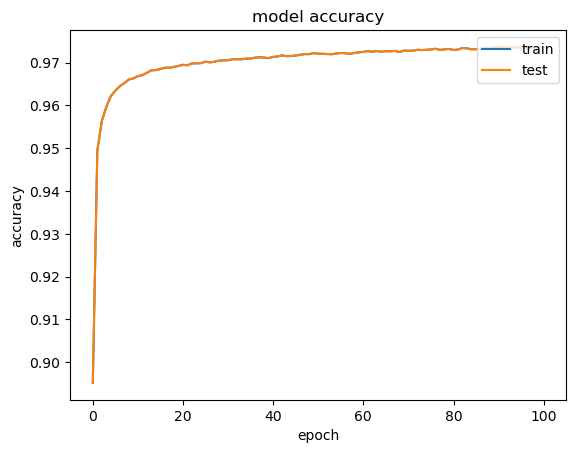

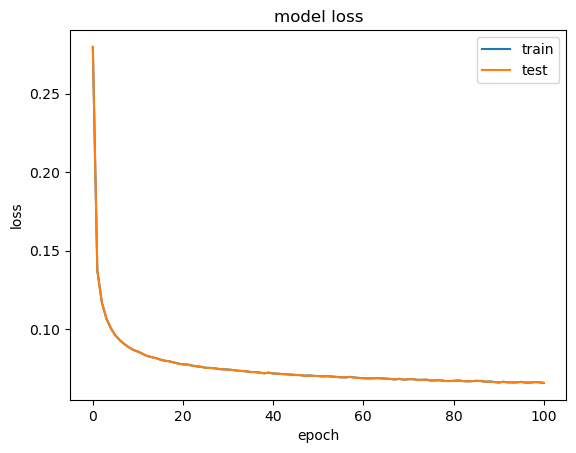

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [14]:
data2001 = numpy.reshape(data2001, newshape=(data2001.shape[0], data2001.shape[1],1,1))
data2004 = numpy.reshape(data2004, newshape=(data2004.shape[0], data2004.shape[1],1,1))
Y_pred=Siamese_vae.predict([data2001,data2004])

16278/16278 [==============================] - 43s 3ms/step


recal: 0.9724857308347259
rmse: 0.29544879758464027
r2: 0.8989201873345954
precision_sc: 0.975146611367338
f1_sc: 0.9738049966449657
tpr: [0.         0.97367666 0.97853811 1.        ]
fpr: [0.         0.02663444 0.26521458 1.        ]
Accuracy: 97.34503420219515


<Axes: >

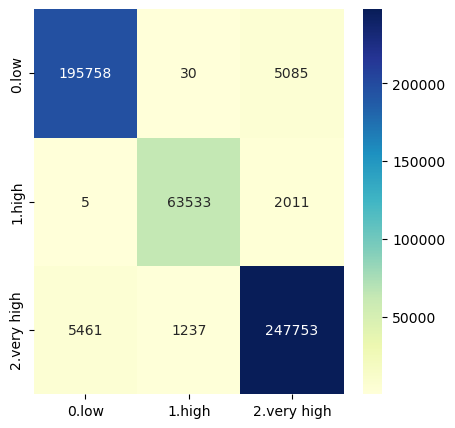

In [15]:
##########################################   Metrix preparation #######################################
from sklearn.metrics import recall_score
mse = sklearn.metrics.mean_squared_error(datay, np.argmax(Y_pred, axis=1))
rmse = math.sqrt(mse)
r2=sklearn.metrics.r2_score(datay, np.argmax(Y_pred, axis=1))
precision_sc=sklearn.metrics.precision_score(datay, np.argmax(Y_pred, axis=1), average='macro')
f1_sc=sklearn.metrics.f1_score(datay, np.argmax(Y_pred, axis=1), average='macro')
confusion_mat=sklearn.metrics.confusion_matrix(datay, np.argmax(Y_pred, axis=1))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(datay, np.argmax(Y_pred, axis=1), pos_label=2)
recall_score=sklearn.metrics.recall_score(datay, np.argmax(Y_pred, axis=1), average='macro')
auc=sklearn.metrics.auc(fpr, tpr)
print('recal:',recall_score)
print('rmse:',rmse)
print('r2:',r2)
print('precision_sc:',precision_sc)
print('f1_sc:',f1_sc)
print('tpr:',tpr[2])
print('fpr:',fpr[2])
from sklearn.metrics import accuracy_score
accuracy=sklearn.metrics.accuracy_score(datay, np.argmax(Y_pred, axis=1))
print('Accuracy:',accuracy*100)
import seaborn as sn
df_cm = pd.DataFrame(confusion_mat, index = ["0.low","1.high","2.very high"],columns = ["0.low","1.high","2.very high"])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")

In [27]:
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
def bootstrap(X1,X2,y,model,n_samples=5):
    accuracy= []
    precision = []
    recall = []
    f1 = []
    fpr= []
    indices_x = []
    for i in range(n_samples):
        index_x = np.random.choice(X1.shape[0], size=10000, replace=True)
        indices_x.append(index_x)
        X_sample1 = X1[index_x, :]
        X_sample2 = X2[index_x, :]
        y_sample = y[index_x]
        y_pred = np.argmax(model.predict([X_sample1,X_sample2]),axis=1)
        accuracy.append ( metrics.accuracy_score(y_sample, y_pred))
        precision.append( metrics.precision_score(y_sample, y_pred, average="macro") )
        recall.append(metrics.recall_score(y_sample, y_pred, average="macro"))
        f1.append(metrics.f1_score(y_sample, y_pred, average="macro"))
        fp, tp, th = metrics.roc_curve(y_sample, y_pred, pos_label=2)
        fpr.append(fp[1])
    return accuracy, precision, recall, f1, fpr
accuracy, precision, recall, f1, fpr  = bootstrap(data2001, data2004, datay, Siamese_vae, 5)
pred_df = pd.DataFrame({"Accuracy": accuracy,"Precision": precision,"Recall": recall,"F1-score": f1,"FPR": fpr})
pred_df.to_excel("D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/bootstrap_SVAE.xlsx", index=False) 
pred_df

313/313 [==============================] - 2s 5ms/step


,Accuracy,Precision,Recall,F1-score,FPR
0,0.9716,0.971993,0.970697,0.971343,0.028948
1,0.9724,0.974406,0.971367,0.972873,0.028239
2,0.9726,0.975719,0.970491,0.973064,0.029209
3,0.9727,0.974063,0.974263,0.974162,0.025782
4,0.9747,0.976263,0.973914,0.975078,0.027074
